# Libraries

In [1]:
import random
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

import matplotlib.pyplot as plt


import pandas as pd


# Random forest models to detect signal sequence in microcins

There are only 10 verified microcin sequences, they all have a signal sequence, but tools like SignalP are unable to correctly identify their signal sequence. Microcins are specific to gram-negative bacteria, but they belong to a broader protein family known as Bacteriocins which are expressed by gram-positive bacteria. 

To create a microcin signal sequence classifier, I will be using Bacteriocin sequences from the BAGEL database. They split Bacteriocins into classes I, II, or III. I took their data and filtered only sequences greater than 30 AA with Methionine as the first AA, and to also have nonredundant sequences. For whatever reason, microcins are grouped into two different bacteriocin classes, but they are included in the BAGEL dataset, so  I identified them and removed them. I then took those sequences and used duomolog to identify sequences similar to the verified microcins. 



## Bacteriocin summary

class |total sequences | microcins | microcin duomologs
------|----------------|-----------|-------------------
I     |483             |6          |6
II    |161             |2          |109
III   |61              |0          |0 

So class III seems to be the most dissimilar to to microcins. I will set it aside and use it as my test negative dataset, if the final model classifies them as microcins, they will be false positives. Class II appears to be the most similar to microcins, so it will serve as the positive dataset.

The verified set of microcins will also be set aside, since their is so few of them, it would be great if I could get a model to correctly classify them without them being included in the training data, they will serve as my positive test dataset. 

Class I (minus the 6 microcins, and 6 microcin duomologs) will have a total of 471 sequences, this will serve as my negative training set. Class II (minus the 6 microcins) will be the positive dataset.

## Load data



In [2]:
def fasta_to_pd(faFile):
    outDict = {"header":[],"seq":[]}
    seqs = SeqIO.parse(faFile, "fasta")
    for record in seqs:
        outDict["header"].append(record.id)
        outDict["seq"].append(str(record.seq))
    outDF = pd.DataFrame.from_dict(outDict)
    return outDF

In [18]:
test_positive = "../data/microcins/verified_microcins.faa"
test_negative_classIII = "../data/BAGEL/classIII.startM_len30.fa"

train_negative_classI = "../data/BAGEL/classI.startM_len30.noMicrocins.noDuomologs.fa"
train_positive_classII = "../data/BAGEL/classII.startM_len30.noMicrocins.fa"

My goal is to set the test datasets entirely aside, and not evaluate them until the final models are ready.

In [19]:
train_negative_classI_DF = fasta_to_pd(train_negative_classI)
train_positive_classII_DF = fasta_to_pd(train_positive_classII)

In [20]:
train_negative_classI_DF

,header,seq
0,Capistruin,MVRLLAKLLRSTIHGSNGVSLDAVSSTHGTPGFQTPDARVISRFGFN
1,Chaxapeptin,MEPQMTELQPEAYEAPSLIEVGEFSEDTLGFGSKPLDSFGLNFF
2,Enterocin_F4-9,MGNSILNKMTVEEMEAVKGGNLVCPPMPDYIKRLSTGKGVSSVYMA...
3,Caulonodin_V,MTQVSPSPLRLIRVGRALDLTRSIGDSGLRESMSSQTYWP
4,Gassericin_E,MKNFNTLSFETLANIVGGRNNLAANIGGVGGATVAGWALGNAVCGP...
...,...,...
469,class_I_lanthipeptide_074,MKKVKKLSLKKEKISSLTNSDMQSIKGGLGDPTAKTAPGSAGSSNH...
470,class_I_lanthipeptide_075,MKTNKFSALQLNKKSIARLNDGQLTSVKGGNRGNQLEDNCTNGGIT...
471,class_I_lanthipeptide_076,MEKKKIQLKNSKLSLKKESVANLSNQDMASLRGGEGGSTCHKVTCS...
472,class_I_lanthipeptide_077,MKSNPFSKLKLNKKSVAKLNKAQLSTVKGGKVVPTQDLNCTELGVT...


In [21]:
train_positive_classII_DF

,header,seq
0,Abp118_alpha,MMKEFTVLTECELAKVDGGKRGPNCVGNFLGGLFAGAAAGVPLGPA...
1,AcdB_acidocin_B,MDKKTKILFEVLYIICIIGPQFILFVTAKNNMYQLVGSFVGIVWFS...
2,Acidocin_8912,MISSHQKTLTDKELALISGGKTHYPTNAWKSLWKGFWESLRYTDGF
3,Acidocin_LF221B(GassericinK7B),MALKTLEKHELRNVMGGNKWGNAVIGAATGATRGVSWCRGFGPWGM...
4,AcidocinA,MISMISSHQKTLTDKELALISGGKTYYGTNGVHCTKKSLWGKVRLK...
...,...,...
150,UviB_2,MEEQIFNSMIQQGAFAALFVWMLFTTQKKNEQREEQYQKVIEKNQD...
151,UviB_3,MDSELFKLMATQGAFAILFSYLLFYVLKENSKREDKYQNIIEELTE...
152,Weissellicin_Y,MANIVLRVGSVAYNYAPKIFKWIGEGVSYNQIIKW
153,Pentocin_KCA1,MVLNLKERLQLNRIEAVVLVALFAAVLLFATVNIVWLANKFGVHLT...


# Data preperation

I will be building random forest models using the first 15 amino acid sequences from the negative and positive dataset converted to Atchley factors.

I'll make a function that yields a list of set of nonredundant 15mer sequences from the N-terminal.

In [30]:
def getNterm15(fastaDF):
    Nterm15 = set()
    for seq in fastaDF["seq"]:
        if len(seq) <16:
            sys.exit("All sequences must be > 16aa")
        Nterm15.add(seq[1:16])
    return Nterm15

positive_Nterm15 = getNterm15(train_positive_classII_DF)
negative_Nterm15 = getNterm15(train_negative_classI_DF)
print(f"pos:{len(positive_Nterm15)}\nneg:{len(negative_Nterm15)}")

pos:141
neg:377


Now we will take those peptides and form a dataframe of Atchley factors

# Atchley factors

The following is a dictionary of the five Atchley factors for each of the 20 amino acids, X and other ambiguity codes/ nonnatural amino acid sequences are given the same value, which represent the average. This could certainly be updated to be somewhat more realistic, it is rare in actual datasets, so it mostly serves as to prevent key errors.


In [26]:
class Factors():
    def __init__(self):
        self.Atchley = {
            "A":[-0.59,-1.30,-0.73,1.57,-0.15],
            "C":[-1.34,0.47,-0.86,-1.02,-0.26],
            "D":[1.05,0.30,-3.66,-0.26,-3.24],
            "E":[1.36,-1.45,1.48,0.11,-0.84],
            "F":[-1.01,-0.59,1.89,-0.40,0.41],
            "G":[-0.38,1.65,1.33,1.05,2.06],
            "H":[0.34,-0.42,-1.67,-1.47,-0.08],
            "I":[-1.24,-0.55,2.13,0.39,0.82],
            "K":[1.83,-0.56,0.53,-0.28,1.65],
            "L":[-1.02,-0.99,-1.51,1.27,-0.91],
            "M":[-0.66,-1.52,2.22,-1.01,1.21],
            "N":[0.95,0.83,1.30,-0.17,0.93],
            "P":[0.19,2.08,-1.63,0.42,-1.39],
            "Q":[0.93,-0.18,-3.01,-0.50,-1.85],
            "R":[1.54,-0.06,1.50,0.44,2.90],
            "S":[-0.23,1.40,-4.76,0.67,-2.65],
            "T":[-0.03,0.33,2.21,0.91,1.31],
            "V":[-1.34,-0.28,-0.54,1.24,-1.26],
            "W":[-0.60,0.01,0.67,-2.13,-0.18],
            "Y":[0.26,0.83,3.10,-0.84,1.51],
            "B":[1,0.565,-1.18,-0.215,-1.155],
            "Z":[1.145,-0.815,-0.765,-0.195,-1.345],
            "J":[-1.13,-0.77,0.31,0.83,-0.045],
            "U":[-0.13,-0.12,0.6,-0.03,-0.115],
            "O":[-0.13,-0.12,0.6,-0.03,-0.115],
            "X":[-0.13,-0.12,0.6,-0.03,-0.115]
        }

In [27]:
def seqList2FactorDF(seqList, factorDict):
    outDict = {}
    for seq in seqList:
        for aaNum in range(len(seq)):
            aa = seq[aaNum]
            factors = factorDict[aa]
            for factorNum in range(len(factors)):
                factor = factors[factorNum]
                header = "aa"+str(aaNum)+"_factor" + str(factorNum)
                if header not in outDict:
                    outDict[header] = []    
                outDict[header].append(factor)
    outDF = pd.DataFrame.from_dict(outDict)
    return outDF

Now we will make the final dataframe that will then be split into training and validation data for the random forest models

In [32]:
positive_Nterm15_atchley = seqList2FactorDF(positive_Nterm15, Factors().Atchley)
positive_Nterm15_atchley["label"] = "pos"
negative_Nterm15_atchley = seqList2FactorDF(negative_Nterm15, Factors().Atchley)
negative_Nterm15_atchley["label"] = "neg"

all_atchley = positive_Nterm15_atchley.append(negative_Nterm15_atchley)

all_atchley


,aa0_factor0,aa0_factor1,aa0_factor2,aa0_factor3,aa0_factor4,aa1_factor0,aa1_factor1,aa1_factor2,aa1_factor3,aa1_factor4,...,aa13_factor1,aa13_factor2,aa13_factor3,aa13_factor4,aa14_factor0,aa14_factor1,aa14_factor2,aa14_factor3,aa14_factor4,label
0,1.83,-0.56,0.53,-0.28,1.65,0.93,-0.18,-3.01,-0.50,-1.85,...,-0.28,-0.54,1.24,-1.26,-1.34,-0.28,-0.54,1.24,-1.26,pos
1,0.95,0.83,1.30,-0.17,0.93,0.95,0.83,1.30,-0.17,0.93,...,-0.99,-1.51,1.27,-0.91,-0.23,1.40,-4.76,0.67,-2.65,pos
2,1.83,-0.56,0.53,-0.28,1.65,-0.03,0.33,2.21,0.91,1.31,...,0.33,2.21,0.91,1.31,-0.03,0.33,2.21,0.91,1.31,pos
3,1.05,0.30,-3.66,-0.26,-3.24,1.83,-0.56,0.53,-0.28,1.65,...,-0.55,2.13,0.39,0.82,-1.34,0.47,-0.86,-1.02,-0.26,pos
4,1.05,0.30,-3.66,-0.26,-3.24,-0.03,0.33,2.21,0.91,1.31,...,-1.30,-0.73,1.57,-0.15,-0.66,-1.52,2.22,-1.01,1.21,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1.54,-0.06,1.50,0.44,2.90,-1.34,-0.28,-0.54,1.24,-1.26,...,-0.06,1.50,0.44,2.90,-0.59,-1.30,-0.73,1.57,-0.15,neg
373,1.36,-1.45,1.48,0.11,-0.84,1.83,-0.56,0.53,-0.28,1.65,...,1.40,-4.76,0.67,-2.65,-1.02,-0.99,-1.51,1.27,-0.91,neg
374,-0.03,0.33,2.21,0.91,1.31,-0.23,1.40,-4.76,0.67,-2.65,...,-0.06,1.50,0.44,2.90,-1.02,-0.99,-1.51,1.27,-0.91,neg
375,-0.23,1.40,-4.76,0.67,-2.65,-0.66,-1.52,2.22,-1.01,1.21,...,1.65,1.33,1.05,2.06,-1.02,-0.99,-1.51,1.27,-0.91,neg


Now we will split the data into validation and training data

In [33]:
atchley_factors = all_atchley.drop('label', axis=1)
labels = all_atchley['label'].copy()

atchley_factors_train, atchley_factors_validate, labels_train, labels_validate = train_test_split(atchley_factors, labels, test_size=0.2, random_state =42, stratify=labels)
atchley_factors_train

,aa0_factor0,aa0_factor1,aa0_factor2,aa0_factor3,aa0_factor4,aa1_factor0,aa1_factor1,aa1_factor2,aa1_factor3,aa1_factor4,...,aa13_factor0,aa13_factor1,aa13_factor2,aa13_factor3,aa13_factor4,aa14_factor0,aa14_factor1,aa14_factor2,aa14_factor3,aa14_factor4
123,1.83,-0.56,0.53,-0.28,1.65,1.83,-0.56,0.53,-0.28,1.65,...,-0.03,0.33,2.21,0.91,1.31,0.95,0.83,1.30,-0.17,0.93
66,0.34,-0.42,-1.67,-1.47,-0.08,1.83,-0.56,0.53,-0.28,1.65,...,1.36,-1.45,1.48,0.11,-0.84,0.93,-0.18,-3.01,-0.50,-1.85
305,-0.23,1.40,-4.76,0.67,-2.65,-1.02,-0.99,-1.51,1.27,-0.91,...,-0.03,0.33,2.21,0.91,1.31,-0.03,0.33,2.21,0.91,1.31
16,1.83,-0.56,0.53,-0.28,1.65,0.93,-0.18,-3.01,-0.50,-1.85,...,-1.24,-0.55,2.13,0.39,0.82,0.95,0.83,1.30,-0.17,0.93
124,1.83,-0.56,0.53,-0.28,1.65,1.83,-0.56,0.53,-0.28,1.65,...,-0.23,1.40,-4.76,0.67,-2.65,0.95,0.83,1.30,-0.17,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,1.83,-0.56,0.53,-0.28,1.65,1.83,-0.56,0.53,-0.28,1.65,...,-1.34,-0.28,-0.54,1.24,-1.26,0.95,0.83,1.30,-0.17,0.93
40,-0.38,1.65,1.33,1.05,2.06,-0.59,-1.30,-0.73,1.57,-0.15,...,-1.24,-0.55,2.13,0.39,0.82,-1.34,-0.28,-0.54,1.24,-1.26
238,1.83,-0.56,0.53,-0.28,1.65,1.83,-0.56,0.53,-0.28,1.65,...,-1.02,-0.99,-1.51,1.27,-0.91,-0.23,1.40,-4.76,0.67,-2.65
11,1.05,0.30,-3.66,-0.26,-3.24,0.19,2.08,-1.63,0.42,-1.39,...,-0.23,1.40,-4.76,0.67,-2.65,1.83,-0.56,0.53,-0.28,1.65


All that is left to do now is to make our model!

# Random forest classifier

In [34]:
class12_rf = RandomForestClassifier(n_estimators=500)

class12_rf.fit(atchley_factors_train, labels_train)

RandomForestClassifier(n_estimators=500)

## ROC curve for validation set

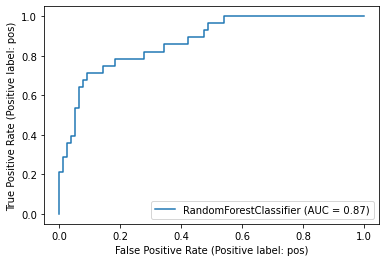

In [36]:
plot_roc_curve(class12_rf, atchley_factors_validate, labels_validate)  
plt.show()

So that isn't entirely terrible! Let's see how it works on the test datasets



In [39]:
test_positive_DF = fasta_to_pd(test_positive)
test_negative_DF = fasta_to_pd(test_negative_classIII)

test_positive_Nterm15 = getNterm15(test_positive_DF)
test_negative_Nterm15 = getNterm15(test_negative_DF)

test_positive_atchley = seqList2FactorDF(test_positive_Nterm15, Factors().Atchley)
test_negative_atchley = seqList2FactorDF(test_negative_Nterm15, Factors().Atchley)


In [41]:
class12_rf.predict(test_positive_atchley)

array(['neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg'], dtype=object)

In [42]:
class12_rf.predict(test_negative_atchley)

array(['neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg',
       'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'neg',
       'neg'], dtype=object)

Well that didn't work. The good news is, that it has a very low false positive rate! At least in terms of microcins... The high "eagerness" to predict things as negative makes me think we should balance out the dataset. 

# Balanced dataset

Now we will make a model using a balanced negative dataset, such that we have 141 random sampled from the negative dataset.

In [45]:

negative_Nterm15_atchley_balanced = negative_Nterm15_atchley.sample(len(positive_Nterm15_atchley))
negative_Nterm15_atchley_balanced["label"] = "neg"

all_atchley_balanced = positive_Nterm15_atchley.append(negative_Nterm15_atchley_balanced)

all_atchley_balanced

,aa0_factor0,aa0_factor1,aa0_factor2,aa0_factor3,aa0_factor4,aa1_factor0,aa1_factor1,aa1_factor2,aa1_factor3,aa1_factor4,...,aa13_factor1,aa13_factor2,aa13_factor3,aa13_factor4,aa14_factor0,aa14_factor1,aa14_factor2,aa14_factor3,aa14_factor4,label
0,1.83,-0.56,0.53,-0.28,1.65,0.93,-0.18,-3.01,-0.50,-1.85,...,-0.28,-0.54,1.24,-1.26,-1.34,-0.28,-0.54,1.24,-1.26,pos
1,0.95,0.83,1.30,-0.17,0.93,0.95,0.83,1.30,-0.17,0.93,...,-0.99,-1.51,1.27,-0.91,-0.23,1.40,-4.76,0.67,-2.65,pos
2,1.83,-0.56,0.53,-0.28,1.65,-0.03,0.33,2.21,0.91,1.31,...,0.33,2.21,0.91,1.31,-0.03,0.33,2.21,0.91,1.31,pos
3,1.05,0.30,-3.66,-0.26,-3.24,1.83,-0.56,0.53,-0.28,1.65,...,-0.55,2.13,0.39,0.82,-1.34,0.47,-0.86,-1.02,-0.26,pos
4,1.05,0.30,-3.66,-0.26,-3.24,-0.03,0.33,2.21,0.91,1.31,...,-1.30,-0.73,1.57,-0.15,-0.66,-1.52,2.22,-1.01,1.21,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-0.23,1.40,-4.76,0.67,-2.65,-1.24,-0.55,2.13,0.39,0.82,...,-1.45,1.48,0.11,-0.84,-1.02,-0.99,-1.51,1.27,-0.91,neg
373,1.36,-1.45,1.48,0.11,-0.84,1.83,-0.56,0.53,-0.28,1.65,...,1.40,-4.76,0.67,-2.65,-1.02,-0.99,-1.51,1.27,-0.91,neg
122,-0.38,1.65,1.33,1.05,2.06,0.95,0.83,1.30,-0.17,0.93,...,-1.45,1.48,0.11,-0.84,-0.59,-1.30,-0.73,1.57,-0.15,neg
248,-1.24,-0.55,2.13,0.39,0.82,1.83,-0.56,0.53,-0.28,1.65,...,-0.56,0.53,-0.28,1.65,0.95,0.83,1.30,-0.17,0.93,neg


In [48]:
atchley_factors_balanced = all_atchley_balanced.drop('label', axis=1)
labels_balanced = all_atchley_balanced['label'].copy()

atchley_factors_train_balanced, atchley_factors_validate_balanced, labels_train_balanced, labels_validate_balanced = train_test_split(atchley_factors_balanced, labels_balanced, test_size=0.2, random_state =42, stratify=labels_balanced)
atchley_factors_train_balanced

,aa0_factor0,aa0_factor1,aa0_factor2,aa0_factor3,aa0_factor4,aa1_factor0,aa1_factor1,aa1_factor2,aa1_factor3,aa1_factor4,...,aa13_factor0,aa13_factor1,aa13_factor2,aa13_factor3,aa13_factor4,aa14_factor0,aa14_factor1,aa14_factor2,aa14_factor3,aa14_factor4
177,-0.66,-1.52,2.22,-1.01,1.21,1.83,-0.56,0.53,-0.28,1.65,...,-0.59,-1.30,-0.73,1.57,-0.15,-0.38,1.65,1.33,1.05,2.06
306,-1.34,-0.28,-0.54,1.24,-1.26,0.95,0.83,1.30,-0.17,0.93,...,-0.59,-1.30,-0.73,1.57,-0.15,0.93,-0.18,-3.01,-0.50,-1.85
176,1.83,-0.56,0.53,-0.28,1.65,1.83,-0.56,0.53,-0.28,1.65,...,-1.34,-0.28,-0.54,1.24,-1.26,-0.03,0.33,2.21,0.91,1.31
139,1.05,0.30,-3.66,-0.26,-3.24,0.95,0.83,1.30,-0.17,0.93,...,-1.02,-0.99,-1.51,1.27,-0.91,0.93,-0.18,-3.01,-0.50,-1.85
261,1.36,-1.45,1.48,0.11,-0.84,1.54,-0.06,1.50,0.44,2.90,...,-1.34,-0.28,-0.54,1.24,-1.26,1.36,-1.45,1.48,0.11,-0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,1.83,-0.56,0.53,-0.28,1.65,0.34,-0.42,-1.67,-1.47,-0.08,...,-1.24,-0.55,2.13,0.39,0.82,0.26,0.83,3.10,-0.84,1.51
324,-0.23,1.40,-4.76,0.67,-2.65,-1.01,-0.59,1.89,-0.40,0.41,...,-1.24,-0.55,2.13,0.39,0.82,1.36,-1.45,1.48,0.11,-0.84
127,1.83,-0.56,0.53,-0.28,1.65,1.83,-0.56,0.53,-0.28,1.65,...,-1.24,-0.55,2.13,0.39,0.82,-0.38,1.65,1.33,1.05,2.06
118,1.83,-0.56,0.53,-0.28,1.65,-0.03,0.33,2.21,0.91,1.31,...,-1.24,-0.55,2.13,0.39,0.82,1.36,-1.45,1.48,0.11,-0.84


In [47]:
class12_balanced_rf = 

,aa0_factor0,aa0_factor1,aa0_factor2,aa0_factor3,aa0_factor4,aa1_factor0,aa1_factor1,aa1_factor2,aa1_factor3,aa1_factor4,...,aa13_factor0,aa13_factor1,aa13_factor2,aa13_factor3,aa13_factor4,aa14_factor0,aa14_factor1,aa14_factor2,aa14_factor3,aa14_factor4
0,1.83,-0.56,0.53,-0.28,1.65,0.93,-0.18,-3.01,-0.50,-1.85,...,-1.34,-0.28,-0.54,1.24,-1.26,-1.34,-0.28,-0.54,1.24,-1.26
1,0.95,0.83,1.30,-0.17,0.93,0.95,0.83,1.30,-0.17,0.93,...,-1.02,-0.99,-1.51,1.27,-0.91,-0.23,1.40,-4.76,0.67,-2.65
2,1.83,-0.56,0.53,-0.28,1.65,-0.03,0.33,2.21,0.91,1.31,...,-0.03,0.33,2.21,0.91,1.31,-0.03,0.33,2.21,0.91,1.31
3,1.05,0.30,-3.66,-0.26,-3.24,1.83,-0.56,0.53,-0.28,1.65,...,-1.24,-0.55,2.13,0.39,0.82,-1.34,0.47,-0.86,-1.02,-0.26
4,1.05,0.30,-3.66,-0.26,-3.24,-0.03,0.33,2.21,0.91,1.31,...,-0.59,-1.30,-0.73,1.57,-0.15,-0.66,-1.52,2.22,-1.01,1.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-0.23,1.40,-4.76,0.67,-2.65,-1.24,-0.55,2.13,0.39,0.82,...,1.36,-1.45,1.48,0.11,-0.84,-1.02,-0.99,-1.51,1.27,-0.91
373,1.36,-1.45,1.48,0.11,-0.84,1.83,-0.56,0.53,-0.28,1.65,...,-0.23,1.40,-4.76,0.67,-2.65,-1.02,-0.99,-1.51,1.27,-0.91
122,-0.38,1.65,1.33,1.05,2.06,0.95,0.83,1.30,-0.17,0.93,...,1.36,-1.45,1.48,0.11,-0.84,-0.59,-1.30,-0.73,1.57,-0.15
248,-1.24,-0.55,2.13,0.39,0.82,1.83,-0.56,0.53,-0.28,1.65,...,1.83,-0.56,0.53,-0.28,1.65,0.95,0.83,1.30,-0.17,0.93


In [49]:
class12_rf_balanced = RandomForestClassifier(n_estimators=500)

class12_rf_balanced.fit(atchley_factors_train_balanced, labels_train_balanced)

RandomForestClassifier(n_estimators=500)

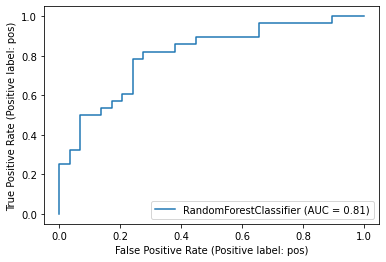

In [50]:
plot_roc_curve(class12_rf_balanced, atchley_factors_validate_balanced, labels_validate_balanced)  
plt.show()

Alright, it's a little more jagged, and less good, maybe it is better on the test dataset??

In [55]:
test_positive_pred = class12_rf_balanced.predict(test_positive_atchley)
test_positive_pred

array(['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg',
       'pos', 'pos', 'neg', 'pos'], dtype=object)

In [56]:
test_negative_pred = class12_rf_balanced.predict(test_negative_atchley)
test_negative_pred

array(['neg', 'neg', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos',
       'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'pos',
       'neg', 'neg', 'pos', 'neg', 'pos', 'neg', 'pos', 'pos', 'neg',
       'pos', 'neg', 'neg', 'pos', 'pos', 'pos', 'pos', 'pos', 'neg',
       'pos'], dtype=object)

In [58]:
false_negatives = list(test_positive_pred).count("neg") / len(test_positive_pred)
false_negatives

0.15384615384615385

In [59]:
false_positives = list(test_negative_pred).count("pos") / len(test_negative_pred)
false_positives

0.5